In [37]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

/kaggle/input
/kaggle/input/cotton-leaf-disease-dataset
/kaggle/input/cotton-leaf-disease-dataset/Augmented Dataset
/kaggle/input/cotton-leaf-disease-dataset/Augmented Dataset/Curl Virus
/kaggle/input/cotton-leaf-disease-dataset/Augmented Dataset/Healthy Leaf
/kaggle/input/cotton-leaf-disease-dataset/Augmented Dataset/Leaf Hopper Jassids
/kaggle/input/cotton-leaf-disease-dataset/Augmented Dataset/Leaf Variegation
/kaggle/input/cotton-leaf-disease-dataset/Augmented Dataset/Leaf Redding
/kaggle/input/cotton-leaf-disease-dataset/Augmented Dataset/Bacterial Blight
/kaggle/input/cotton-leaf-disease-dataset/Augmented Dataset/Herbicide Growth Damage
/kaggle/input/pretrained-models


In [38]:
import tensorflow as tf

## **Dataset Split Into 70% Train, 15% Validation, 15% Test**

In [39]:
import tensorflow as tf

# Define constants
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
DATASET_PATH = "/kaggle/input/cotton-leaf-disease-dataset/Augmented Dataset"

# Load dataset with 70% training and 30% validation+testing
print('Training Data\n')
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.3,  # 30% of data for validation+test
    subset="training",
    seed=42
)

print(f'\nValidation + Test Data\n')
validation_data = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.3,  # 30% of data
    subset="validation",
    seed=42
)

# Get the number of batches in validation_data
val_batches = tf.data.experimental.cardinality(validation_data).numpy()

# Compute split sizes (15% test, 15% validation)
test_size = val_batches // 2  # 15% (half of 30% dataset)
val_size = val_batches - test_size  # Remaining 15%

# Split validation_data into test and validation
test_dataset = validation_data.take(test_size)
validation_dataset = validation_data.skip(test_size)

# Print the dataset sizes
print("\n\n")
print(f"Train batches: {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"Validation batches: {tf.data.experimental.cardinality(validation_dataset).numpy()}")
print(f"Test batches: {tf.data.experimental.cardinality(test_dataset).numpy()}")


Training Data

Found 7000 files belonging to 7 classes.
Using 4900 files for training.

Validation + Test Data

Found 7000 files belonging to 7 classes.
Using 2100 files for validation.



Train batches: 154
Validation batches: 33
Test batches: 33


In [40]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [41]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./127.5, offset=-1),         # Normalize pixel values (0-1)
    layers.RandomRotation(0.111),     # ±20-degree rotation (20/180)
    layers.RandomTranslation(0.2, 0.2),  # Width & Height shift ±20%
    # layers.RandomShear(0.2),          # Shearing transformation
    layers.RandomZoom(0.2),           # Zoom in/out by ±20%
    layers.RandomFlip("horizontal"),  # Flip images horizontally
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [42]:
# Create the base model from the pre-trained model MobileNet V2

IMG_SHAPE = IMG_SIZE + (3,) #---> (224, 224, 3)


weights_path = "/kaggle/input/pretrained-models/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5"

# include_top=False { Means Dont inclue the last layer }
base_model = tf.keras.applications.MobileNetV2(weights=weights_path, include_top=False, input_shape=IMG_SHAPE)

In [43]:
base_model.trainable = False

In [21]:
# base_model.summary()

In [44]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(7, activation='softmax')

In [45]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs, name="cotton_leaf_disease_model_v2")

In [46]:
model.summary()

Model: "cotton_leaf_disease_model_v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_2 (TrueDivide)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_2 (Subtract)                │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │           8,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [47]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=base_learning_rate, weight_decay=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

In [48]:
# Training The Model
initial_epochs = 10
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)

Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 115s 697ms/step - accuracy: 0.1256 - loss: 1.9758 - val_accuracy: 0.1082 - val_loss: 1.9275
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 108s 699ms/step - accuracy: 0.0850 - loss: 1.9495 - val_accuracy: 0.1015 - val_loss: 1.9168
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 105s 681ms/step - accuracy: 0.0895 - loss: 1.9401 - val_accuracy: 0.0996 - val_loss: 1.9043
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 100s 648ms/step - accuracy: 0.0960 - loss: 1.9352 - val_accuracy: 0.0967 - val_loss: 1.8943
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 92s 595ms/step - accuracy: 0.0722 - loss: 1.9303 - val_accuracy: 0.1216 - val_loss: 1.8852
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 91s 591ms/step - accuracy: 0.1071 - loss: 1.9173 - val_accuracy: 0.0795 - val_loss: 1.8783
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 91s 592ms/step - accuracy: 0.0984 - loss: 1.9065 - val_accuracy: 0.1284 - val_loss: 1.8662
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 93s 600ms/step - accuracy: 0.0800 - los

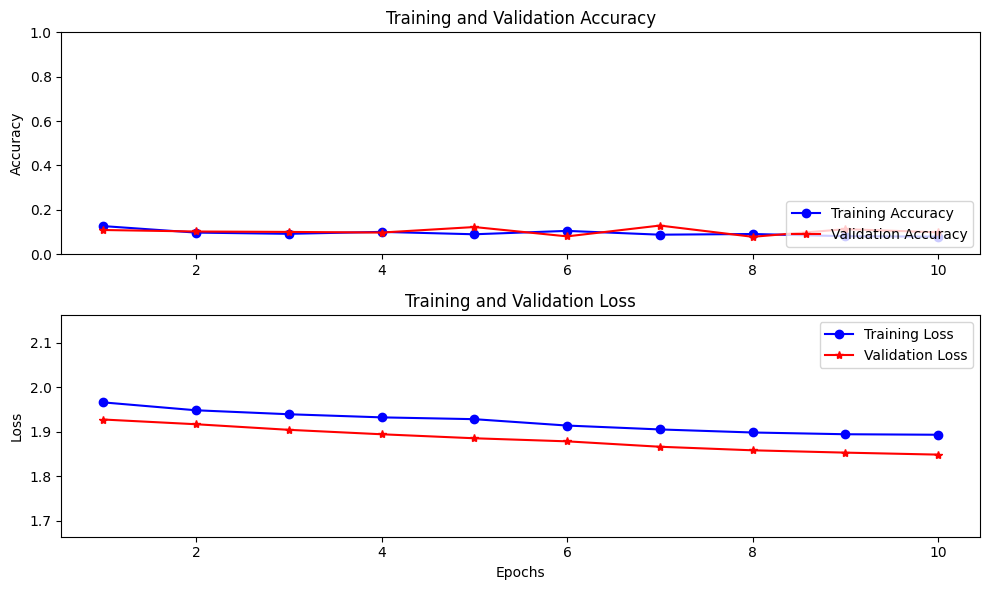

In [49]:
import matplotlib.pyplot as plt

# Assuming 'history' is your model's training history
acc = history.history['accuracy']
val_acc = history.history.get('val_accuracy', [])  # Handles cases where validation is missing
loss = history.history['loss']
val_loss = history.history.get('val_loss', [])

epochs = range(1, len(acc) + 1)  # Ensure correct epoch range

plt.figure(figsize=(10, 6))

# Plot Training & Validation Accuracy
plt.subplot(2, 1, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])  # Ensures accuracy stays between 0 and 1
plt.title('Training and Validation Accuracy')

# Plot Training & Validation Loss
plt.subplot(2, 1, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([min(loss + val_loss) * 0.9, max(loss + val_loss) * 1.1])  # Dynamic range
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')

plt.tight_layout()
plt.show()


# **Fine Tuning**

In [50]:
# Un-freeze the top layers of the model
base_model.trainable = True

In [51]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [52]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # For integer labels
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)


In [53]:
model.summary()

Model: "cotton_leaf_disease_model_v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_2 (TrueDivide)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_2 (Subtract)                │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │           8,967 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 1,870,407 (7.14 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [54]:
len(model.trainable_variables)

56

In [55]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 141s 845ms/step - accuracy: 0.1887 - loss: 2.8608 - val_accuracy: 0.1513 - val_loss: 1.9343
Epoch 12/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 130s 845ms/step - accuracy: 0.2661 - loss: 1.8196 - val_accuracy: 0.1408 - val_loss: 2.1219
Epoch 13/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 127s 825ms/step - accuracy: 0.3156 - loss: 1.7358 - val_accuracy: 0.1437 - val_loss: 2.0669
Epoch 14/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 120s 778ms/step - accuracy: 0.3276 - loss: 1.7051 - val_accuracy: 0.1667 - val_loss: 2.0593
Epoch 15/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 128s 829ms/step - accuracy: 0.3364 - loss: 1.6711 - val_accuracy: 0.1561 - val_loss: 2.0118
Epoch 16/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 151s 887ms/step - accuracy: 0.3697 - loss: 1.6281 - val_accuracy: 0.1542 - val_loss: 1.9876
Epoch 17/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 122s 790ms/step - accuracy: 0.3543 - loss: 1.6221 - val_accuracy: 0.1456 - val_loss: 2.0311
Epoch 18/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 148s 826ms/step - accuracy: 

In [56]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

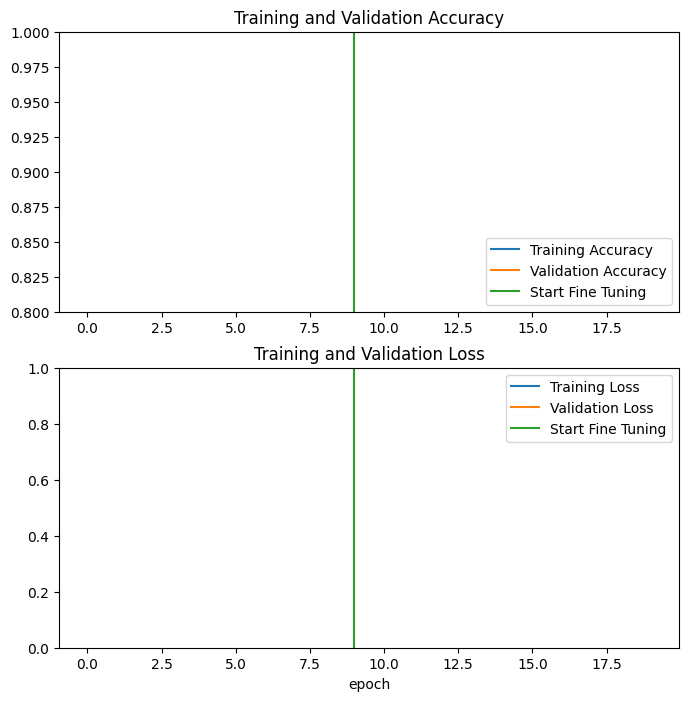

In [60]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Evaluation and Prediction**

In [61]:
class_names = train_dataset.class_names

AttributeError: '_PrefetchDataset' object has no attribute 'class_names'

In [59]:
# Retrieve a batch of images from the test set

image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

AttributeError: '_PrefetchDataset' object has no attribute 'class_names'